In [21]:
from typing import Annotated
import sqlite3

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from pydantic import BaseModel, Field
from typing import Literal

from smart_inventory_bot.app_properties.constant import DATABASE_SCHEMA
from smart_inventory_bot.components.sqlite_utils import sqlite_exc
from smart_inventory_bot.components.cohere_utils import cohere_text_generation
import cohere
from dotenv import load_dotenv
import os
load_dotenv()

cohere_api_key = os.getenv('COHERE_API_KEY')

In [22]:
import instructor
from pydantic import BaseModel
from cohere import Client

client = instructor.from_cohere(Client())

In [23]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    sql_query : str
    data : list[tuple]
    prompt : str

graph_builder = StateGraph(State)

NODES

In [24]:
class prompt_generator(BaseModel):
    """This function answer for natural language questions like a inventory manager"""
    final_ans : str = Field(..., description=f"""
        You are an AI trained model that answers natural language questions like a inventory manager.
    """)

In [25]:
def llm_ai(state: State):
    resp = client.chat.completions.create(
        response_model=prompt_generator,
        messages=[
            {
                "role": "user",
                "content": state["messages"][0].content,
            }
        ],
    )

    print(resp.final_ans)
    return {"messages": resp.final_ans}

In [26]:
# What are the most common order sizes (quantity) and their associated total sales?

In [27]:
class sql_query_generator(BaseModel):
    """This function generates fully formed SQL query for the given user question and database schema"""
    sql_query: str = Field(..., description=f"""
        You are an AI trained to convert natural language questions into Sqlite queries based on a given database schema. Below is the schema description of the database you will be querying:
        {DATABASE_SCHEMA}
        The query should be returned in plain text, not in JSON. The query should be without using placeholders like <value>. The goal is to list out all the results directly without specifying any placeholder.
    """)

In [28]:
def sql_query_gen(state: State):
    resp = client.chat.completions.create(
        response_model=sql_query_generator,
        messages=[
            {
                "role": "user",
                "content": state["messages"][0].content,
            }
        ],
    )

    print(resp.sql_query)
    return {"sql_query": resp.sql_query}


In [29]:
class semantic_routing(BaseModel):
    """This function determines the appropriate path to use based on the user question"""
    path: Literal['llm_ai', 'sql_query_gen'] = Field(..., description=f"""
        You are an AI trained to determine the appropriate path to use based on a given user question. 
        If you think that the user question is related to Database schema and the tables and columns mentioned in the schema are enough to answer, then return 'sql_query_gen' otherwise return 'llm_ai' 
        Below is the schema description of the databases:
        {DATABASE_SCHEMA}
    """)

In [30]:
def where_to_go(state: State):
    resp = client.chat.completions.create(
        response_model=semantic_routing,
        messages=[
            {
                "role": "user",
                "content": state["messages"][0].content,
            }
        ],
    )

    print(resp)
    return resp.path

In [31]:
def sql_agent(state: State):
    data = sqlite_exc(state["sql_query"])
    print(data)
    return {'data' : data}

In [32]:
def where_to_go_if_error(state: State):
    if state['data'] == "error":
        return 'error_in_fetching'
    else:
        return 'llm_final_response'

In [33]:
def error_in_fetching(state: State):
    return {"messages": "Couldn't fetch the data. Kindly provide more descriptive query"}


In [34]:
def llm_final_response(state: State):
    prompt = f"""
    Based on the user question, SQL query and SQL response, generate a clear and concise natural language response that directly answers the question without referencing the database schema or SQL process.
    {DATABASE_SCHEMA}
    Question: {state['messages'][0].content}
    SQL Response: {state['data']}
    SQL query: {state['sql_query']}
    """

    generated_text = cohere_text_generation(prompt, temperature=0.5)
    return {"messages": generated_text}
    

In [35]:
graph_builder.add_node("llm_ai", llm_ai)
graph_builder.add_node("sql_query_gen", sql_query_gen)
graph_builder.add_node("sql_agent", sql_agent)
graph_builder.add_node("error_in_fetching", error_in_fetching)
graph_builder.add_node("llm_final_response", llm_final_response)


graph_builder.add_conditional_edges(
    START,
    where_to_go,
    {"llm_ai": "llm_ai", "sql_query_gen": "sql_query_gen"},

)
graph_builder.add_edge("sql_query_gen", "sql_agent")

graph_builder.add_conditional_edges(
    'sql_agent',
    where_to_go_if_error,
    {"error_in_fetching": "error_in_fetching", "llm_final_response": "llm_final_response"},

)

graph_builder.add_edge("llm_ai", END)
graph_builder.add_edge("llm_final_response", END)
graph_builder.add_edge("error_in_fetching", END)

graph = graph_builder.compile()

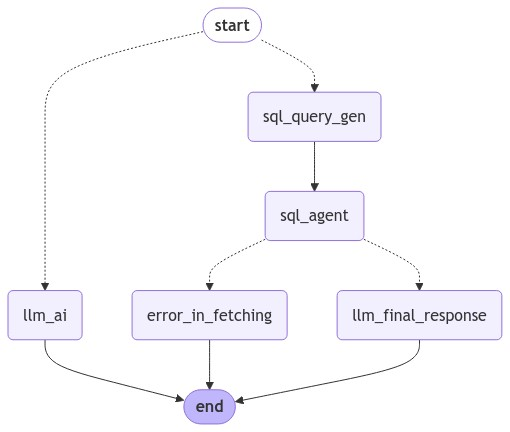

In [36]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [37]:
final_state = graph.invoke(
    {"messages": ("user", "What is the average discount percentage given in each product category over the past year?")}
)

path='sql_query_gen'
SELECT Category_Name, AVG(Discount) AS Average_Discount
FROM Category
INNER JOIN Product ON Category.Category_ID = Product.Category_ID
INNER JOIN Order_Detail ON Product.Product_ID = Order_Detail.Product_ID
GROUP BY Category_Name;
Start Establishing Connection
Connection Established
Query Execution started
Query Executed
[('Clothing', 5.0), ('Electronics', 0.0), ('Furniture', 10.0)]


In [38]:
final_state['messages'][-1].content

'The average discount percentage for each product category over the past year is as follows: Clothing items had a 5% average discount, Electronics had no discount, and Furniture saw an average discount of 10%.'

In [39]:
# import cohere
# co = cohere.Client(cohere_api_key)
# response = co.chat(
#         model="command-r-plus",
#         message=query,
#         temperature=0,
#         )
# print(response.text)

In [40]:
data = sqlite_exc("SELECT Staff.Staff_ID, Staff.First_Name, Staff.Last_Name, COUNT(`Order`.Order_ID) AS Total_Orders, SUM(Order_Detail.Total) AS Total_Revenue FROM Staff LEFT JOIN Customer ON Staff.Staff_ID = Customer.Staff_ID LEFT JOIN `Order` ON Customer.Customer_ID = `Order`.Customer_ID LEFT JOIN Order_Detail ON `Order`.Order_ID = Order_Detail.Order_ID WHERE `Order`.Date_of_Order BETWEEN '2024-08-01' AND '2024-08-31' GROUP BY Staff.Staff_ID, Staff.First_Name, Staff.Last_Name;")
print(data)

Start Establishing Connection
Connection Established
Query Execution started
Query Executed
[(1, 'John', 'Doe', 1, 999.9), (2, 'Jane', 'Smith', 1, 359.8), (3, 'Emily', 'Johnson', 1, 227.7)]
